In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split

import loralib as lora
from segment_anything.modeling.image_encoder import ImageEncoderViT, Block, Attention
from segment_anything.utils.transforms import ResizeLongestSide

import glob
import os
import csv
import shutil
import time

import re
from collections import OrderedDict


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=100):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 


def applyLoRA_vit(model: ImageEncoderViT, r=16, alpha=16):
    block: Block
    for block in model.blocks:
        attn: Attention = block.attn

        old_qkv = attn.qkv
        attn.qkv = lora.MergedLinear(
            old_qkv.in_features,
            old_qkv.out_features,
            r=r,
            enable_lora=[True, False, True],
            fan_in_fan_out=False,
            merge_weights=False,
        )
        attn.qkv.weight.data = old_qkv.weight.data.clone()
        if old_qkv.bias is not None:
            attn.qkv.bias.data = old_qkv.bias.data.clone()

        old_proj = attn.proj
        attn.proj = lora.Linear(
            old_proj.in_features,
            old_proj.out_features,
            r=r,
            fan_in_fan_out=False,
            merge_weights=False,
        )
        attn.proj.weight.data = old_proj.weight.data.clone()
        if old_proj.bias is not None:
            attn.proj.bias.data = old_proj.bias.data.clone()


def applyLoRA_tinyvit(model, r=16, alpha=16):
    for layer in model.layers:
        if hasattr(layer, "blocks"):  # BasicLayer has blocks
            for block in layer.blocks:
                if hasattr(block, "attn"):
                    attn = block.attn
                    
                    old_qkv = attn.qkv
                    attn.qkv = lora.MergedLinear(
                        old_qkv.in_features,
                        old_qkv.out_features,
                        r=r,
                        enable_lora=[True, False, True],
                        fan_in_fan_out=False,
                        merge_weights=False,
                    )
                    attn.qkv.weight.data = old_qkv.weight.data.clone()
                    if old_qkv.bias is not None:
                        attn.qkv.bias.data = old_qkv.bias.data.clone()

                    old_proj = attn.proj
                    attn.proj = lora.Linear(
                        old_proj.in_features,
                        old_proj.out_features,
                        r=r,
                        fan_in_fan_out=False,
                        merge_weights=False,
                    )
                    attn.proj.weight.data = old_proj.weight.data.clone()
                    if old_proj.bias is not None:
                        attn.proj.bias.data = old_proj.bias.data.clone()
    return model



def applyBitFit_vit(model):
    for p in model.parameters():
        p.requires_grad = False

    for name, param in model.image_encoder.named_parameters():
        if name.endswith(".bias"):
            param.requires_grad = True


def applyBitFit_tinyvit(model):
    for p in model.parameters():
        p.requires_grad = False

    for name, param in model.image_encoder.named_parameters():
        if name.endswith(".bias"):
            param.requires_grad = True



def bitfit_state_dict(model):
    sd = model.state_dict()
    keep = OrderedDict()
    for k, v in sd.items():
        mod = model
        try:
            param = dict(model.named_parameters())[k]
            if param.requires_grad and k.endswith(".bias"):
                keep[k] = v
        
        except KeyError:
            pass

    return keep


def load_bitfit_state_dict(model, bias_sd, strict = False):
    model.load_state_dict(bias_sd, strict=strict)


def diceLoss(predictionMask, targetMask, eps=1e-6):
    pred = predictionMask.sigmoid().flatten(1)
    target = targetMask.float().flatten(1)
    intersection = (pred * target).sum(-1)
    union = pred.sum(-1) + target.sum(-1)
    dice = (2 * intersection + eps) / (union + eps)
    return 1 - dice.mean()

def computeIoU(predictionMask, targetMask, threshold=0.5, eps=1e-6):
    predictionBin = (predictionMask.sigmoid() > threshold).float()
    targetBin = targetMask.float()
    
    intersection = (predictionBin * targetBin).sum()
    union = predictionBin.sum() + targetBin.sum() - intersection
    
    return (intersection + eps) / (union + eps)

def computeDice(predictionMask, targetMask, threshold=0.5, eps=1e-6):
    predictionBin = (predictionMask.sigmoid() > threshold).float()
    targetBin = targetMask.float()
    
    intersection = (predictionBin * targetBin).sum()
    union = predictionBin.sum() + targetBin.sum()

    dice = (2 * intersection + eps) / (union + eps)
    return dice


def trainOneEpoch(model, dataloader, optimizer, scheduler, device, currModelName):
    model.train()
    totalLoss = 0.0

    for batch in dataloader:
        
        images = batch["image"].to(device)#.unsqueeze(0)
        masks_gt = batch["mask"].to(device)#.unsqueeze(0)
        points = batch["points"].to(device)#.unsqueeze(0)
        labels = batch["labels"].to(device)#.unsqueeze(0)

        
        imageEmbeddings = model.image_encoder(images)

        sparsePromptEmbeddings, densePromptEmbeddings = model.prompt_encoder(
            points=(points, labels),
            boxes=None,
            masks=None,
        )

        if (currModelName == "tinySam"):
            masks_pred, iousPredictions = model.mask_decoder(
                image_embeddings=imageEmbeddings,
                image_pe=model.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparsePromptEmbeddings,
                dense_prompt_embeddings=densePromptEmbeddings
            )

            masks_pred = F.interpolate(
                masks_pred,
                size=masks_gt.shape[-2:],
                mode="bilinear",
                align_corners=False
            )

            if (masks_pred.shape[1] != masks_gt.shape[1]):
                masks_pred = masks_pred[:, 0:1, :, :]
        else:
            masks_pred, iousPredictions = model.mask_decoder(
                image_embeddings=imageEmbeddings,
                image_pe=model.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparsePromptEmbeddings,
                dense_prompt_embeddings=densePromptEmbeddings,
                multimask_output=False
            )




        # loss = diceLoss(masks_pred, masks_gt) + F.binary_cross_entropy_with_logits(
        #     masks_pred, masks_gt
        # )

        loss = diceLoss(masks_pred, masks_gt)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        totalLoss += loss.item()

    return totalLoss / len(dataloader)


def evaluateValidationOneEpoch(model, dataloader, device, currModelName):
    model.train(False)
    totalLoss = []
    totalIoU = []
    totalDice = []
    # totalLoss = 0.0
    # totalIoU = 0.0
    # totalDice = 0.0
    # numSamples = 0

    for batch in dataloader:
        
        images = batch["image"].to(device)#.unsqueeze(0)
        masks_gt = batch["mask"].to(device)#.unsqueeze(0)
        points = batch["points"].to(device)#.unsqueeze(0)
        labels = batch["labels"].to(device)#.unsqueeze(0)

        
        imageEmbeddings = model.image_encoder(images)

        sparsePromptEmbeddings, densePromptEmbeddings = model.prompt_encoder(
            points=(points, labels),
            boxes=None,
            masks=None,
        )

        if (currModelName == "tinySam"):
            masks_pred, iousPredictions = model.mask_decoder(
                image_embeddings=imageEmbeddings,
                image_pe=model.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparsePromptEmbeddings,
                dense_prompt_embeddings=densePromptEmbeddings
            )

            masks_pred = F.interpolate(
                masks_pred,
                size=masks_gt.shape[-2:],
                mode="bilinear",
                align_corners=False
            )

            if (masks_pred.shape[1] != masks_gt.shape[1]):
                masks_pred = masks_pred[:, 0:1, :, :]
        else:
            masks_pred, iousPredictions = model.mask_decoder(
                image_embeddings=imageEmbeddings,
                image_pe=model.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparsePromptEmbeddings,
                dense_prompt_embeddings=densePromptEmbeddings,
                multimask_output=False
            )




        # loss = diceLoss(masks_pred, masks_gt) + F.binary_cross_entropy_with_logits(
        #     masks_pred, masks_gt
        # )

        loss = diceLoss(masks_pred, masks_gt)
        totalLoss.append(loss.item())
        # totalLoss += loss.item()

        IoU = computeIoU(masks_pred, masks_gt)
        totalIoU.append(IoU.item())
        # totalIoU += IoU.item()

        Dice = computeDice(masks_pred, masks_gt)
        totalDice.append(Dice.item())
        # totalDice += Dice.item()

        # numSamples += 1

    # return totalLoss / numSamples, totalIoU / numSamples, totalDice / numSamples
    model.train(True)
    return np.mean(totalLoss), np.mean(totalIoU), np.mean(totalDice)




def evaluateTestOneEpoch(model, dataloader, device, currModelName):
    model.train(False)
    totalLoss = []
    totalIoU = []
    totalDice = []
    # totalLoss = 0.0
    # totalIoU = 0.0
    # totalDice = 0.0
    numSamples = 0
    peakMemoryUsage = []
    inferenceTimes = []

    for batch in dataloader:
        
        if torch.cuda.is_available():
            torch.cuda.reset_peak_memory_stats(device)

        images = batch["image"].to(device)#.unsqueeze(0)
        masks_gt = batch["mask"].to(device)#.unsqueeze(0)
        points = batch["points"].to(device)#.unsqueeze(0)
        labels = batch["labels"].to(device)#.unsqueeze(0)

        
        startTime = time.perf_counter()
        imageEmbeddings = model.image_encoder(images)

        sparsePromptEmbeddings, densePromptEmbeddings = model.prompt_encoder(
            points=(points, labels),
            boxes=None,
            masks=None,
        )

        if (currModelName == "tinySam"):
            masks_pred, iousPredictions = model.mask_decoder(
                image_embeddings=imageEmbeddings,
                image_pe=model.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparsePromptEmbeddings,
                dense_prompt_embeddings=densePromptEmbeddings
            )

            masks_pred = F.interpolate(
                masks_pred,
                size=masks_gt.shape[-2:],
                mode="bilinear",
                align_corners=False
            )

            if (masks_pred.shape[1] != masks_gt.shape[1]):
                masks_pred = masks_pred[:, 0:1, :, :]
        else:
            masks_pred, iousPredictions = model.mask_decoder(
                image_embeddings=imageEmbeddings,
                image_pe=model.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparsePromptEmbeddings,
                dense_prompt_embeddings=densePromptEmbeddings,
                multimask_output=False
            )

        endTime = time.perf_counter()
        inferenceTimes.append(endTime - startTime)

        if torch.cuda.is_available():
            peakMemoryDuringPrediction = torch.cuda.max_memory_allocated(device)
            peakMemoryUsage.append(peakMemoryDuringPrediction)


        # loss = diceLoss(masks_pred, masks_gt) + F.binary_cross_entropy_with_logits(
        #     masks_pred, masks_gt
        # )

        loss = diceLoss(masks_pred, masks_gt)
        totalLoss.append(loss.item())
        # totalLoss += loss.item()

        IoU = computeIoU(masks_pred, masks_gt)
        totalIoU.append(IoU.item())
        # totalIoU += IoU.item()

        Dice = computeDice(masks_pred, masks_gt)
        totalDice.append(Dice.item())
        # totalDice += Dice.item()

        numSamples += 1

    # Get max memory and convert to MB
    maxMemory = np.max(peakMemoryUsage) / (1024 ** 2) if peakMemoryUsage else 0

    # Get mean latency and convert to ms
    avgInferenceLatency = np.mean(inferenceTimes) * 1000 if inferenceTimes else 0

    # return totalLoss, totalIoU, totalDice, numSamples, maxMemory, avgInferenceLatency
    model.train(True)
    return totalLoss, totalIoU, totalDice, numSamples, maxMemory, avgInferenceLatency

def normalizeImage(imgChw: torch.Tensor):
    PIXEL_MEAN = torch.tensor([123.675, 116.28, 103.53]) / 255.0
    PIXEL_STD  = torch.tensor([58.395, 57.12, 57.375]) / 255.0

    imgChw = imgChw / 255.0
    
    return (imgChw - PIXEL_MEAN[:, None, None]) / PIXEL_STD[:, None, None]

class CityscapesCars(Dataset):

    def __init__(self, imageFiles, labelFiles, targetClass=26):
        
        self.imageFiles = imageFiles
        self.labelFiles = labelFiles
        self.targetClass = targetClass

        self.samImageEncoderSize = 1024 # Defined in the ImageEncoderViT
        self.transform = ResizeLongestSide(self.samImageEncoderSize)



    def __len__(self):
        return len(self.imageFiles)
    
    def __getitem__(self,  index):

        image = cv2.imread(self.imageFiles[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        originalImageH, originalImageW = image.shape[:2]

        image_resized = cv2.resize(image, (1024, 1024), interpolation=cv2.INTER_LINEAR)
        image_tensor = torch.as_tensor(image_resized).permute(2, 0, 1).float()
        image_tensor = normalizeImage(image_tensor)

        labels = cv2.imread(self.labelFiles[index], cv2.IMREAD_UNCHANGED)
        mask = (labels == self.targetClass).astype(np.uint8)

        # Point prompts inside the mask (positive)
        posPointPromptsAmount = 2
        ys, xs = np.where(mask > 0)
        posCoords = []
        for _ in range(posPointPromptsAmount):
            posIndex = np.random.randint(0, len(xs))
            posCoords.append([xs[posIndex], ys[posIndex]])

        posCoords = np.array(posCoords, dtype=np.float32)
        posLabels = np.ones(posPointPromptsAmount, dtype=np.int32)
        # pointCoords = np.array([[xs[indexChoice], ys[indexChoice]]], dtype=np.float32)
        # pointLabels = np.array([1], dtype=np.int32)

        # Point prompts outside the mask (negative)
        negPointPromptsAmount = 3
        neg_ys, neg_xs = np.where(mask == 0)
        negCoords = []
        for _ in range(negPointPromptsAmount):
            negIndex = np.random.randint(0, len(neg_xs))
            negCoords.append([neg_xs[negIndex], neg_ys[negIndex]])

        negCoords = np.array(negCoords, dtype=np.float32)
        negLabels = np.zeros(negPointPromptsAmount, dtype=np.int32)

        pointCoords = np.vstack([posCoords, negCoords])
        pointLabels = np.concatenate([posLabels, negLabels])

        scaleX = 1024 / originalImageW
        scaleY = 1024 / originalImageH

        pointCoords = pointCoords * np.array([scaleX, scaleY], dtype=np.float32)

        mask_resized = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)

        sample = {
            "image":  image_tensor, #torch.tensor(image).permute(2, 0, 1).float(),
            "mask": torch.tensor(mask_resized).unsqueeze(0).float(),
            "points": torch.tensor(pointCoords).float(),
            "labels": torch.tensor(pointLabels).long()
        }

        return sample


def imageHasCar(labelFile, targetClass=26):
    labels = cv2.imread(labelFile, cv2.IMREAD_UNCHANGED)
    return (labels == targetClass).any()




class ModelContainer():

    def __init__(self, modelVariant, modelVariantPredictorClass, modelVariantName, modelBaseName):
        self.modelVariant = modelVariant
        self.modelVariantPredictorClass = modelVariantPredictorClass
        self.modelVariantName = modelVariantName
        self.modelBaseName = modelBaseName



def samplePoints(mask, numPositivePoints, numNegativePoints):
    ysPos, xsPos = np.where(mask > 0)
    ysNeg, xsNeg = np.where(mask == 0)

    posIndices = np.random.choice(len(xsPos), size=numPositivePoints, replace=False)
    negIndices = np.random.choice(len(xsNeg), size=numNegativePoints, replace=False)

    posPoints = np.stack([xsPos[posIndices], ysPos[posIndices]], axis=1)
    negPoints = np.stack([xsNeg[negIndices], ysNeg[negIndices]], axis=1)

    points = np.concatenate([posPoints, negPoints], axis=0).astype(np.float32)
    labels = np.concatenate([np.ones(len(posPoints)), np.zeros(len(negPoints))], axis=0).astype(np.int32)

    return points, labels

def visualizeModelComparison(imageFile, labelFile, baselineModels, finetunedModels, device):
    image = cv2.imread(imageFile)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    labels = cv2.imread(labelFile, cv2.IMREAD_UNCHANGED)
    gtMask = (labels == 26).astype(np.uint8)

    H, W = image.shape[:2]

    numPositivePoints = 2
    numNegativePoints = 3
    pointsOrig, labelsResized = samplePoints(gtMask, numPositivePoints, numNegativePoints)

    # pointsOrig = np.array([[1850, 550], [1250, 450], [1150, 750], [500, 500], [900, 250]])
    # labelsResized = np.array([1, 1, 0, 0, 0])


    fig, axs = plt.subplots(2, 2, figsize=(12,8))
    axs = axs.flatten()

    axs[0].imshow(image)
    show_mask(gtMask, axs[0])
    show_points(pointsOrig, labelsResized, axs[0])
    axs[0].set_title("Input image")
    # axs[0].axis('off')
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[0].set_xlabel("Ground truth w/ point prompts")
    
    for i in range(1, 4):
        # axs[i].axis('off')
        axs[i].set_xticks([])
        axs[i].set_yticks([])

    for j, mdl in enumerate(baselineModels):
        predictor = mdl.modelVariantPredictorClass(mdl.modelVariant)
        predictor.set_image(image)
        masks, scores, _ = predictor.predict(
            point_coords=pointsOrig,
            point_labels=labelsResized
        )

        # masks, scores, _ = predictor.predict()

        bestMask = masks[scores.argmax()]

        axs[j+1].imshow(image)
        show_mask(bestMask, axs[j+1])
        axs[j+1].set_title(f"{mdl.modelBaseName} ({mdl.modelVariantName})")
        axs[j+1].set_xlabel("Predicted mask")

    plt.tight_layout()
    plt.savefig("./results/BaselinePredictionsComparison.png")
    plt.show()
    plt.close()


    fig, axs = plt.subplots(2, 3, figsize=(18, 8))
    axs = axs.flatten()

    for i in range(len(finetunedModels)):
        axs[i].set_xticks([])
        axs[i].set_yticks([])

    for j, mdl in enumerate(finetunedModels):
        predictor = mdl.modelVariantPredictorClass(mdl.modelVariant)
        predictor.set_image(image)
        masks, scores, _ = predictor.predict(
            point_coords=pointsOrig,
            point_labels=labelsResized
        )

        bestMask = masks[scores.argmax()]

        axs[j].imshow(image)
        show_mask(bestMask, axs[j])
        axs[j].set_title(f"{mdl.modelBaseName} ({mdl.modelVariantName})")
        axs[j].set_xlabel("Predicted mask")

    plt.tight_layout()
    plt.savefig("./results/FinetunedPredictionsComparison.png")
    plt.show()
    plt.close()

def DEBUG_CountTrainableParameters(model):
    total = 0
    for n, p in model.named_parameters():
        if p.requires_grad:
            total += p.numel()

    return total


def TestModelVariant(testLoss, testIoU, testDice, maxMemoryUsed, avgInferenceLatency, resultsPath, modelVariantName, modelBaseName):
    
    print("\nTesting the model..")
    
    avgTestLoss = np.mean(testLoss)
    avgTestIoU = np.mean(testIoU)
    avgTestDice = np.mean(testDice)
    stdTestLoss = np.std(testLoss)
    stdTestIoU = np.std(testIoU)
    stdTestDice = np.std(testDice)
    throughput = 1000 / avgInferenceLatency

    print("\n======== Test Results ========")
    print(f"Test mLoss: {avgTestLoss:.4f}")
    print(f"Test mIoU: {avgTestIoU:.4f}")
    print(f"Test mDice: {avgTestDice:.4f}")
    print(f"Test maxMemoryUsed: {maxMemoryUsed:.2f} MB")
    print(f"Test avgInferenceLatency: {avgInferenceLatency:.2f} ms")
    print("==============================\n")
    print("\n ==== DEBUG =====")
    print(f"loss: {testLoss}")
    print(f"IoU: {testIoU}")
    print(f"Dice: {testDice}")
    print("==============================\n")

    testResultsCsvFile = os.path.join(resultsPath, f"{modelVariantName}_{modelBaseName}_test_results.csv")
    with open(testResultsCsvFile, mode="a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Mean Test Loss", 
                         "Std Test Loss",
                         "Mean Test IoU",
                         "Std Test IoU", 
                         "Mean Test Dice",
                         "Std Test Dice", 
                         "Test maxMemoryUsed", 
                         "Mean Test InferenceLatency",
                         "Throughput"])
        
        writer.writerow([f"{avgTestLoss:.3f}",
                         f"{stdTestLoss:.2f}",
                         f"{avgTestIoU:.3f}",
                         f"{stdTestIoU:.2f}", 
                         f"{avgTestDice:.3f}",
                         f"{stdTestDice:.2f}", 
                         f"{maxMemoryUsed:.2f}", 
                         f"{avgInferenceLatency:.2f}",
                         f"{throughput:.2f}"])


    print("Testing finished")



In [2]:
import sys
sys.path.extend([
    "./segment-anything",
    "./MobileSAM",
    "./TinySAM"
])

from segment_anything import sam_model_registry as samModelReg, SamPredictor as samPred, build_sam, build_sam_vit_b, build_sam_vit_h, build_sam_vit_l
from mobile_sam import sam_model_registry as mobileSamModelReg, SamPredictor as mobileSamPred, build_sam_vit_t as mobile_build_sam_vit_t
from tinysam import sam_model_registry as tinySamModelReg, SamPredictor as tinySamPred, build_sam_vit_t as tiny_build_sam_vit_t

device = "cuda" if torch.cuda.is_available() else "cpu"

# Setting up each of the models and their respective predictors

#SAM
samCheckpointViTB = "./model_weights/sam_vit_b_01ec64.pth"
samCheckpointViTH = "./model_weights/sam_vit_h_4b8939.pth"
samCheckpointViTL = "./model_weights/sam_vit_l_0b3195.pth"
mobileSamCheckpoint = "./model_weights/mobile_sam.pt"
tinySamCheckpoint = "./model_weights/tinysam_42.3.pth"

# LoRASam = build_sam_vit_l(checkpoint=samCheckpointViTL)
# sam = build_sam_vit_h(checkpoint=samCheckpointViTH)
BaselineSam = build_sam_vit_b(checkpoint=samCheckpointViTB)
BaselineMobileSam = mobile_build_sam_vit_t(checkpoint=mobileSamCheckpoint)
BaselineTinySam = tiny_build_sam_vit_t(checkpoint=tinySamCheckpoint)

LoRASam = build_sam_vit_b(checkpoint=samCheckpointViTB)
LoRAMobileSam = mobile_build_sam_vit_t(checkpoint=mobileSamCheckpoint)
LoRATinySam = tiny_build_sam_vit_t(checkpoint=tinySamCheckpoint)

BitFitSam = build_sam_vit_b(checkpoint=samCheckpointViTB)
BitFitMobileSam = mobile_build_sam_vit_t(checkpoint=mobileSamCheckpoint)
BitFitTinySam = tiny_build_sam_vit_t(checkpoint=tinySamCheckpoint)
print("Built the models")

applyLoRA_vit(LoRASam.image_encoder)
applyLoRA_tinyvit(LoRAMobileSam.image_encoder)
applyLoRA_tinyvit(LoRATinySam.image_encoder)
print("Applied LoRA")

lora.mark_only_lora_as_trainable(LoRASam)
lora.mark_only_lora_as_trainable(LoRAMobileSam)
lora.mark_only_lora_as_trainable(LoRATinySam)
print("Freezing everything except LoRA")

applyBitFit_vit(BitFitSam)
applyBitFit_tinyvit(BitFitMobileSam)
applyBitFit_tinyvit(BitFitTinySam)
print("Applied BitFit")

BaselineSam.to(device=device)
BaselineMobileSam.to(device=device)
BaselineTinySam.to(device=device)

LoRASam.to(device=device)
LoRAMobileSam.to(device=device)
LoRATinySam.to(device=device)

BitFitSam.to(device=device)
BitFitMobileSam.to(device=device)
BitFitTinySam.to(device=device)

BaselineSam.train(False)
BaselineMobileSam.train(False)
BaselineTinySam.train(False)

LoRASam.train()
LoRAMobileSam.train()
LoRATinySam.train()

BitFitSam.train()
BitFitMobileSam.train()
BitFitTinySam.train()

# currModel = "tinySam"

# if (currModel == "mobileSam"):
#     model = mobileSam
#     predictorClass = mobileSamPred
#     modelName = currModel
# elif (currModel == "tinySam"):
#     model = tinySam
#     predictorClass = tinySamPred
#     modelName = currModel
# else:
#     model = sam
#     predictorClass = samPred
#     modelName = currModel
# print(f"Current model is: {currModel}")

BaselineSamModelContainer = ModelContainer(BaselineSam, samPred, "Baseline", "sam")
BaselineMobileSamModelContainer = ModelContainer(BaselineMobileSam, mobileSamPred, "Baseline", "mobileSam")
BaselineTinySamModelContainer = ModelContainer(BaselineTinySam, tinySamPred, "Baseline", "tinySam")

baselineModelContainerList = [
    BaselineSamModelContainer,
    BaselineMobileSamModelContainer,
    BaselineTinySamModelContainer
]

LoRASamModelContainer = ModelContainer(LoRASam, samPred, "LoRA", "sam")
LoRAMobileSamModelContainer = ModelContainer(LoRAMobileSam, mobileSamPred, "LoRA", "mobileSam")
LoRATinySamContainer = ModelContainer(LoRATinySam, tinySamPred, "LoRA", "tinySam")

BitFitSamModelContainer = ModelContainer(BitFitSam, samPred, "BitFit", "sam")
BitFitMobileSamModelContainer = ModelContainer(BitFitMobileSam, mobileSamPred, "BitFit", "mobileSam")
BitFitTinySamModelContainer = ModelContainer(BitFitTinySam, tinySamPred, "BitFit", "tinySam")

# FOR TESTING ONLY -- REMOVE AFTER TESTING IS DONE
# finetunedModelContainerList = [BitFitSamModelContainer]

# finetunedModelContainerList = []

finetunedModelContainerList = [LoRASamModelContainer,
                               LoRAMobileSamModelContainer,
                               LoRATinySamContainer,
                               BitFitSamModelContainer,
                               BitFitMobileSamModelContainer,
                               BitFitTinySamModelContainer]

print("")
trainImages = sorted(glob.glob("./Datasets/leftImg8bit/train/*/*_leftImg8bit.png"))
trainLabels = sorted(glob.glob("./Datasets/gtFine/train/*/*_labelIds.png"))

print(f"trainImages length is: {len(trainImages)}")
print(f"trainLabels length is: {len(trainLabels)}")

validationImages = sorted(glob.glob("./Datasets/leftImg8bit/val/*/*_leftImg8bit.png"))
validationLabels = sorted(glob.glob("./Datasets/gtFine/val/*/*_labelIds.png"))


# These images don't work, use a 20% split from validation data instead as test data
# testImages = sorted(glob.glob("../Datasets/leftImg8bit/test/*/*_leftImg8bit.png"))
# testLabels = sorted(glob.glob("../Datasets/gtFine/test/*/*_labelIds.png"))

validationImages, testImages, validationLabels, testLabels = train_test_split(
    validationImages, validationLabels, test_size=0.2, random_state=42
)

print(f"validationImages length is: {len(validationImages)}")
print(f"validationLabels length is: {len(validationLabels)}")

print(f"testImages length is: {len(testImages)}")
print(f"testLabels length is: {len(testLabels)}")


amountOfDataImages = 100

print("")
print("Sorting training data..")
filteredTrainImages, filteredTrainLabels = [], []
for imageFile, labelFile in zip(trainImages, trainLabels):
    # if len(filteredTrainImages) < amountOfDataImages:
        if imageHasCar(labelFile, targetClass=26):
            filteredTrainImages.append(imageFile)
            filteredTrainLabels.append(labelFile)
print("Finished sorting training data")
print(f"Sorted training data has: {len(filteredTrainImages)} images, {len(filteredTrainLabels)} labels")

print("")
print("Sorting validation data..")
filteredValidationImages, filteredValidationLabels = [], []
for imageFile, labelFile in zip(validationImages, validationLabels):
    # if len(filteredValidationImages) < amountOfDataImages:
        if imageHasCar(labelFile, targetClass=26):
            filteredValidationImages.append(imageFile)
            filteredValidationLabels.append(labelFile)
print("Finished sorting validation data")
print(f"Sorted validation data has: {len(filteredValidationImages)} images, {len(filteredValidationLabels)} labels")


# The test data provided in the Cityscapes gtFine dataset contains some unusuable data and thus we are then instead splitting
#   the validation dataset into validation data (80%) and test data (20%)
print("")
print("Sorting test data..")
filteredTestImages, filteredTestLabels = [], []
for imageFile, labelFile in zip(testImages, testLabels):
    # if len(filteredTestImages) < amountOfDataImages:
        if imageHasCar(labelFile, targetClass=26):
            filteredTestImages.append(imageFile)
            filteredTestLabels.append(labelFile)
print("Finished sorting test data")
print(f"Sorted test data has: {len(filteredTestImages)} images, {len(filteredTestLabels)} labels")


print("")
print("Initializing Training DataSet and DataLoader")
trainDataset = CityscapesCars(filteredTrainImages, filteredTrainLabels, targetClass=26)
trainLoader = DataLoader(trainDataset, batch_size=1, shuffle=True)

print("Initializing Validation DataSet and DataLoader")
validationDataset = CityscapesCars(filteredValidationImages, filteredValidationLabels, targetClass=26)
validationLoader = DataLoader(validationDataset, batch_size=1, shuffle=True)

print("Initializing Test DataSet and DataLoader")
testDataset = CityscapesCars(filteredTestImages, filteredTestLabels, targetClass=26)
testLoader = DataLoader(testDataset, batch_size=1, shuffle=True)

# Removes results folder complete, including all sub-directories and files
if os.path.exists("./results"):
    shutil.rmtree("./results")

c:\Users\adamf\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\adamf\AppData\Local\Programs\Python\Python312\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
c:\Users\adamf\AppData\Local\Programs\Python\Python312\Lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
c:\users\adamf\appdata\roaming\datalogi\datalogi - atia\project\code\mobilesam\mobile_sam\modeling\tiny_vit_sam.

Built the models
Applied LoRA
Freezing everything except LoRA
Applied BitFit

trainImages length is: 2975
trainLabels length is: 2975
validationImages length is: 400
validationLabels length is: 400
testImages length is: 100
testLabels length is: 100

Sorting training data..
Finished sorting training data
Sorted training data has: 2832 images, 2832 labels

Sorting validation data..
Finished sorting validation data
Sorted validation data has: 382 images, 382 labels

Sorting test data..
Finished sorting test data
Sorted test data has: 97 images, 97 labels

Initializing Training DataSet and DataLoader
Initializing Validation DataSet and DataLoader
Initializing Test DataSet and DataLoader


In [3]:
def trainModel(modelVariant, modelVariantPredictorClass, modelVariantName, modelBaseName, resultsPath):
    print("")
    print("")
    print(f"Current model variant: {modelVariantName}")
    print(f"Current model base: {modelBaseName}")
    print("")
    print("")
    print(f"Current model trainable params: {DEBUG_CountTrainableParameters(modelVariant)}")
    print("")
    print("")
    print("Creating optimizer")
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, modelVariant.parameters()), lr=1e-4, weight_decay=1e-4
    )

    # Setting this to some high amount. Early stopping should (hoepfully) be hit before then.
    numEpochs = 40
    stepsPerEpoch = len(trainLoader)
    totalSteps = numEpochs * stepsPerEpoch


    warmupEpochs = 5
    warmupSteps = warmupEpochs * stepsPerEpoch
    warmupScheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        start_factor=0.1,
        total_iters=warmupSteps
    )

    cosineScheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=totalSteps - warmupSteps,
        eta_min=1e-6
    )

    scheduler = torch.optim.lr_scheduler.SequentialLR(
        optimizer, schedulers=[warmupScheduler, cosineScheduler], milestones=[warmupSteps]
    )

    trainingLoss = []
    validationLoss = []
    validationIoU = []
    validationDice = []

    
    earlyStopping_Patience = 5
    earlyStopping_BestSeenValidationLoss = float("inf")
    earlyStopping_BestEpochSeen = 0
    earlyStopping_PatienceCounter = 0
    bestWeights = {}

    # resultsPath = f"./results/{modelVariantName}/{modelBaseName}/"

    # os.makedirs(resultsPath, exist_ok=True)

    print("Starting training..")
    for epochIndex, epoch in enumerate(range(numEpochs)):

        loss = trainOneEpoch(modelVariant, trainLoader, optimizer, scheduler, device, modelBaseName)
        trainingLoss.append(loss)

        valLoss, valIoU, valDice = evaluateValidationOneEpoch(modelVariant, validationLoader, device, modelBaseName)
        validationLoss.append(valLoss)
        validationIoU.append(valIoU)
        validationDice.append(valDice)
        print(f"Epoch {epoch+1}, Training Loss: {loss:.4f}")
        print(f"Epoch {epoch+1}, Validation Loss: {valLoss:.4f}, Validation IoU: {valIoU:.4f}, Validation Dice: {valDice:.4f}")

        epochResultsCsvFile = os.path.join(resultsPath, f"{modelVariantName}_{modelBaseName}_epoch_results.csv")
        willWriteHeader = not os.path.exists(epochResultsCsvFile)
        with open(epochResultsCsvFile, mode="a", newline="") as f:
            writer = csv.writer(f)
            if willWriteHeader:
                writer.writerow(["Epoch", "Train Loss", "Val Loss", "Val IoU", "Val Dice"])

            writer.writerow([epoch+1, f"{loss:.6f}", f"{valLoss:.6f}", f"{valIoU:.6f}", f"{valDice:.6f}"])

        modelVariant.eval()

        # Early stopping check
        if valLoss < earlyStopping_BestSeenValidationLoss:
            earlyStopping_BestSeenValidationLoss = valLoss
            earlyStopping_BestEpochSeen = epochIndex
            earlyStopping_PatienceCounter = 0

            if modelVariantName == "LoRA":
                bestWeights[f"{modelBaseName}_{modelVariantName}"] = lora.lora_state_dict(modelVariant)

            if modelVariantName == "BitFit":
                bestWeights[f"{modelBaseName}_{modelVariantName}"] = bitfit_state_dict(modelVariant)
        else:
            earlyStopping_PatienceCounter += 1

        if earlyStopping_PatienceCounter >= earlyStopping_Patience:
            print(f"\nEarly stopping at epoch {epochIndex+1}")
            print(f"Best epoch was {earlyStopping_BestEpochSeen+1} with validation loss {earlyStopping_BestSeenValidationLoss:.4f}")
            break

        with torch.no_grad():

            randomTestImageIndex = np.random.randint(0, len(trainDataset) - 1)
            # print(f"Random Index for prediction was: {randomTestImageIndex}")

            sample = trainDataset[randomTestImageIndex]

            image_np = cv2.imread(filteredTrainImages[randomTestImageIndex])
            image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)

            imageOriginalH, imageOriginalW = image_np.shape[:2]

            trainH, trainW = 1024, 1024


            # point_coords = sample["points"].cpu().numpy()
            # point_labels = sample["labels"].cpu().numpy()

            # px, py = sample["points"][0].cpu().numpy()
            # px = int(px * (imageOriginalW / trainW))
            # py = int(py * (imageOriginalH / trainH))
            # originalPointCoords = np.array([[px, py]])
            # originalPointLabels =  sample["labels"].cpu().numpy()
            
            points_resized = sample["points"].cpu().numpy()
            labels_resized = sample["labels"].cpu().numpy()

            points_orig = points_resized.copy()
            points_orig[:, 0] = points_resized[:, 0] * (imageOriginalW / trainW)
            points_orig[:, 1] = points_resized[:, 1] * (imageOriginalH / trainH)


            predictor = modelVariantPredictorClass(modelVariant)
            predictor.set_image(image_np)

            # print(currModel)

            if (modelBaseName == "tinySam"):
                masks, scores, logits = predictor.predict(
                    point_coords=points_orig,
                    point_labels=labels_resized
                )
            else:
                masks, scores, logits = predictor.predict(
                    point_coords=points_orig,
                    point_labels=labels_resized,
                    multimask_output=True
                )
            
            
            indexBest = int(scores.argmax())
            maskShow = masks[indexBest]
            scoreShow = float(scores[indexBest])




            fig, axs = plt.subplots(1, 2, figsize=(20,10))

            # Prediction Visualization
            # axs[0][0].imshow(image_np)
            # show_mask(maskShow, axs[0][0])
            # show_points(points_orig, labels_resized, axs[0][0])
            # axs[0][0].axis('off')
            # axs[0][0].set_title(f"Epoch {epoch+1}, Score: {scoreShow}")

            # Training Loss
            axs[0].plot(range(1, len(trainingLoss) + 1), trainingLoss, marker="o", label="Training Loss")
            axs[0].set_xlabel("Epoch")
            axs[0].set_ylabel("Loss")
            axs[0].set_title(f"{modelBaseName} ({modelVariantName}) - Training Loss")
            axs[0].grid(False)
            axs[0].legend()

            # Validation Loss
            # axs[1][0].plot(range(1, len(validationLoss) + 1), validationLoss, marker="o", label="Validation Loss")
            # axs[1][0].set_xlabel("Epoch")
            # axs[1][0].set_ylabel("Loss")
            # axs[1][0].set_title(f"{modelName} (LoRA) - Validation Loss")
            # axs[1][0].grid(True)
            # axs[1][0].legend()

            # Validation IoU
            axs[1].plot(range(1, len(validationIoU) + 1), validationIoU, marker="o", label="IoU", color='green')
            axs[1].plot(range(1, len(validationDice) + 1), validationDice, marker="^", label="Dice", color='magenta')
            axs[1].set_xlabel("Epoch")
            axs[1].set_ylabel("Score")
            axs[1].set_title(f"{modelBaseName} ({modelVariantName}) - Validation")
            axs[1].grid(False)
            axs[1].legend()


            plt.savefig(f"{resultsPath}{modelVariantName}_{modelBaseName}_Epoch{epochIndex+1}_Aggregate.png")
            # plt.show()
            plt.clf()
            plt.close()

            # Visualize a prediction with the current fine-tuning
            plt.figure(figsize=(8,8))
            plt.imshow(image_np)
            show_mask(maskShow, plt.gca())
            show_points(points_orig, labels_resized, plt.gca())
            plt.title(f"{modelBaseName} ({modelVariantName}) - Epoch {epoch+1}, Score: {scoreShow}")
            plt.axis("off")
            plt.savefig(f"{resultsPath}{modelVariantName}_{modelBaseName}_Epoch{epochIndex+1}_PredictionVisual")
            # plt.show()
            plt.clf()
            plt.close()

            # Visualize all training loss seen up until now
            plt.figure(figsize=(6,4))
            plt.plot(range(1, len(trainingLoss) + 1), trainingLoss, marker="o", label="Training Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title(f"{modelBaseName} ({modelVariantName}) - Training Loss")
            plt.grid(False)
            plt.legend()
            plt.savefig(f"{resultsPath}{modelVariantName}_{modelBaseName}_Epoch{epochIndex+1}_TrainingLossGraph")
            # plt.show()
            plt.clf()
            plt.close()

            # Visualize all validation loss seen up until now
            plt.figure(figsize=(6,4))
            plt.plot(range(1, len(validationLoss) + 1), validationLoss, marker="o", label="Validation Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title(f"{modelBaseName} ({modelVariantName}) - Validation Loss")
            plt.grid(False)
            plt.legend()
            plt.savefig(f"{resultsPath}{modelVariantName}_{modelBaseName}_Epoch{epochIndex+1}_ValidationLossGraph")
            # plt.show()
            plt.clf()
            plt.close()

            # Visualize all IoU and Dice seen up until now
            plt.figure(figsize=(6,4))
            plt.plot(range(1, len(validationIoU) + 1), validationIoU, marker="o", label="IoU")
            plt.plot(range(1, len(validationDice) + 1), validationDice, marker="^", label="Dice")
            plt.xlabel("Epoch")
            plt.ylabel("Score")
            plt.title(f"{modelBaseName} ({modelVariantName}) - Validation")
            plt.grid(False)
            plt.legend()
            plt.savefig(f"{resultsPath}{modelVariantName}_{modelBaseName}_Epoch{epochIndex+1}_IoUDiceGraph")
            # plt.show()
            plt.clf()
            plt.close()

            


        modelVariant.train()


    print("Training finished")

    # Restoring best weights, if modelVariantName != "baseline"
    if modelVariantName == "LoRA":
        modelVariant.load_state_dict(bestWeights[f"{modelBaseName}_{modelVariantName}"], strict=False)

    if modelVariantName == "BitFit":
        load_bitfit_state_dict(modelVariant, bestWeights[f"{modelBaseName}_{modelVariantName}"])

    testLoss, testIoU, testDice, numSamples, maxMemoryUsed, avgInferenceLatency = evaluateTestOneEpoch(modelVariant, testLoader, device, modelBaseName)


    if (modelVariantName == "LoRA"):
        LoRAWeightsPath = os.path.join(resultsPath, f"{modelVariantName}_{modelBaseName}_lora.pth")
        torch.save(lora.lora_state_dict(modelVariant), LoRAWeightsPath)
        print(f"Saving LoRA checkpoint in: {LoRAWeightsPath}")

    if (modelVariantName == "BitFit"):
        BitFitWeightsPath = os.path.join(resultsPath, f"{modelVariantName}_{modelBaseName}_bitfit.pth")
        torch.save(bitfit_state_dict(modelVariant), BitFitWeightsPath)
        print(f"Saving BitFit checkpoint in: {BitFitWeightsPath}")

    return testLoss, testIoU, testDice, maxMemoryUsed, avgInferenceLatency


Testing the model..

======== Test Results ========
Test mLoss: 0.4823
Test mIoU: 0.4285
Test mDice: 0.5592
Test maxMemoryUsed: 15389.33 MB
Test avgInferenceLatency: 227.95 ms


 ==== DEBUG =====
loss: [0.19576358795166016, 0.6487399935722351, 0.32532304525375366, 0.63118577003479, 0.958329975605011, 0.9329159259796143, 0.2554669976234436, 0.23177570104599, 0.5088868141174316, 0.41256511211395264, 0.7946261763572693, 0.8491750955581665, 0.2715441584587097, 0.7176470756530762, 0.45127809047698975, 0.4672834873199463, 0.4270365238189697, 0.5271801352500916, 0.2986302375793457, 0.08807510137557983, 0.4947686791419983, 0.6472609043121338, 0.810286819934845, 0.6326917409896851, 0.24311691522598267, 0.6231517791748047, 0.6142195463180542, 0.40572118759155273, 0.40695899724960327, 0.7490401268005371, 0.8784124851226807, 0.07216709852218628, 0.3702833652496338, 0.14212965965270996, 0.36156946420669556, 0.7777678966522217, 0.4593198895454407, 0.6452363729476929, 0.044244349002838135, 0.8228776

c:\Users\adamf\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 5, Training Loss: 0.1061
Epoch 5, Validation Loss: 0.1175, Validation IoU: 0.8195, Validation Dice: 0.8847
Epoch 6, Training Loss: 0.0977
Epoch 6, Validation Loss: 0.1053, Validation IoU: 0.8334, Validation Dice: 0.8965
Epoch 7, Training Loss: 0.0911
Epoch 7, Validation Loss: 0.0989, Validation IoU: 0.8413, Validation Dice: 0.9027
Epoch 8, Training Loss: 0.0860
Epoch 8, Validation Loss: 0.0991, Validation IoU: 0.8416, Validation Dice: 0.9023
Epoch 9, Training Loss: 0.0824
Epoch 9, Validation Loss: 0.1005, Validation IoU: 0.8419, Validation Dice: 0.9005
Epoch 10, Training Loss: 0.0774
Epoch 10, Validation Loss: 0.0954, Validation IoU: 0.8485, Validation Dice: 0.9057
Epoch 11, Training Loss: 0.0760
Epoch 11, Validation Loss: 0.0931, Validation IoU: 0.8523, Validation Dice: 0.9080
Epoch 12, Training Loss: 0.0747
Epoch 12, Validation Loss: 0.0914, Validation IoU: 0.8552, Validation Dice: 0.9097
Epoch 13, Training Loss: 0.0727
Epoch 13, Validation Loss: 0.0913, Validation IoU: 0.8550,

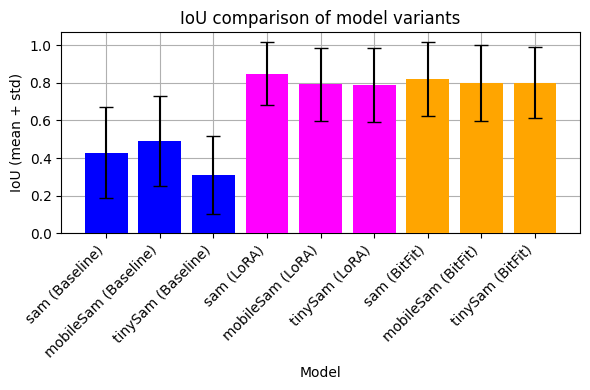

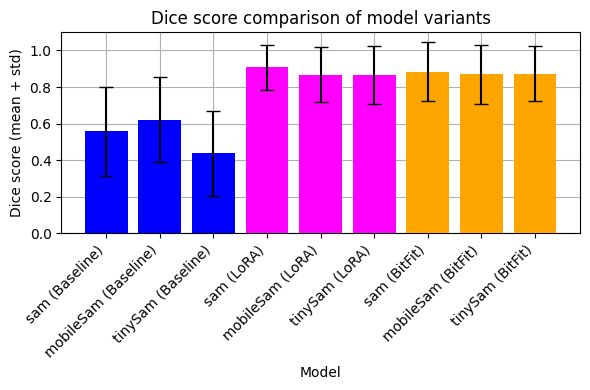

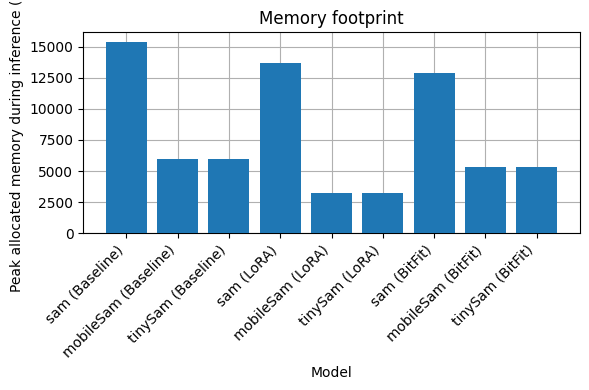

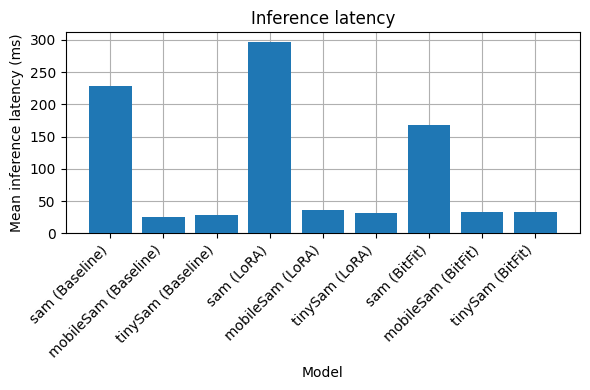

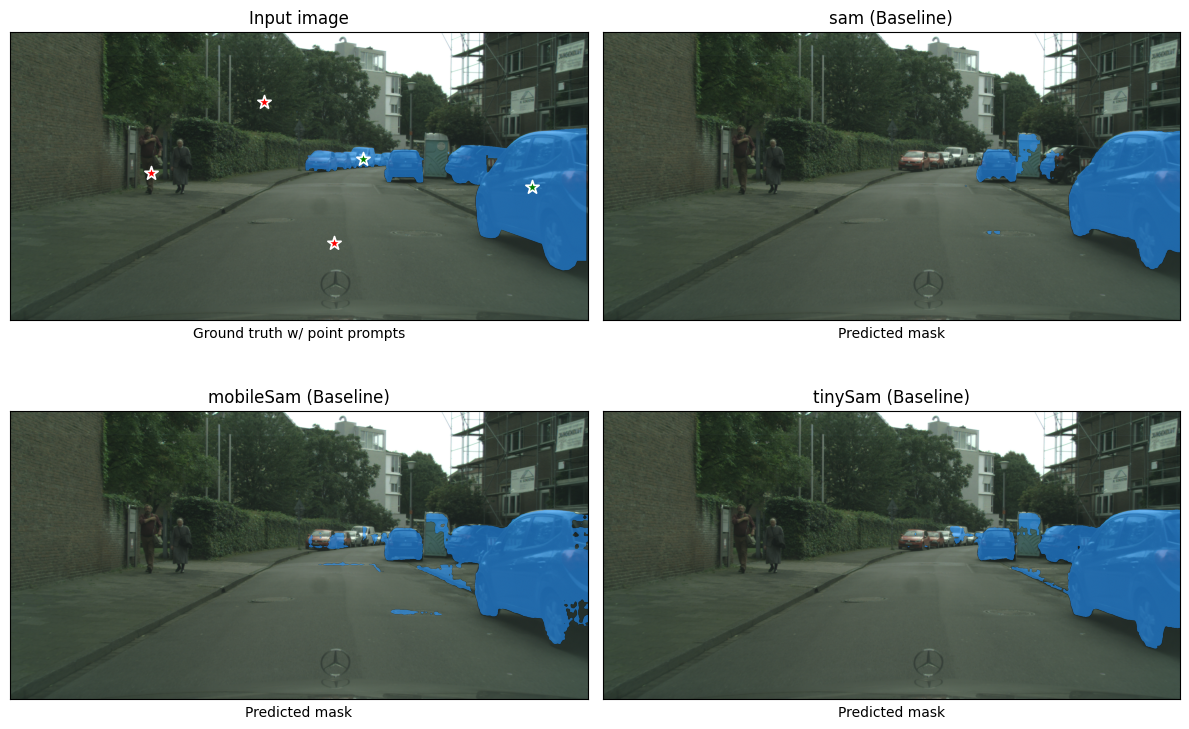

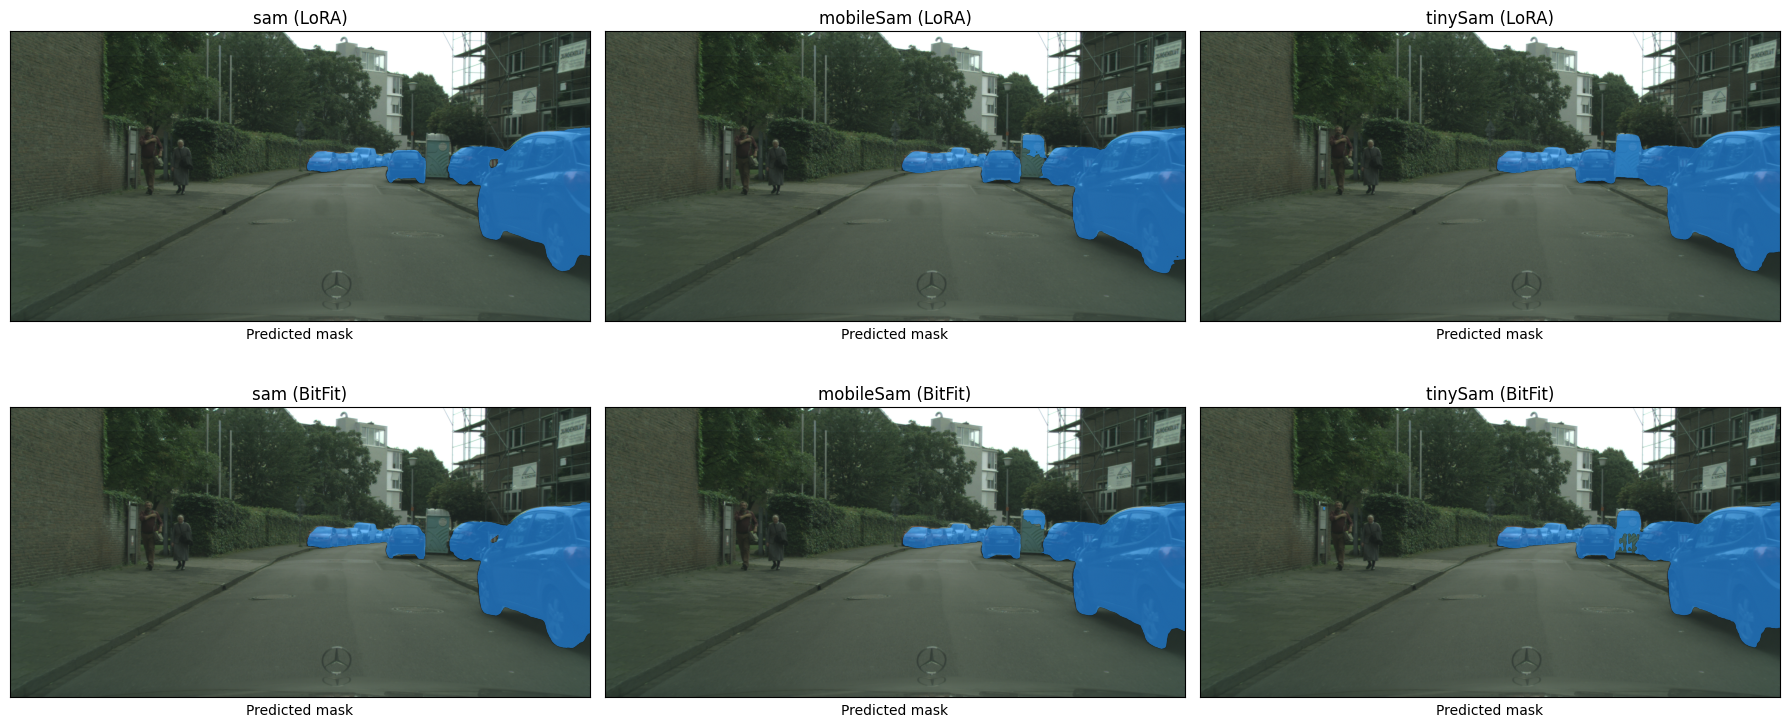

In [4]:
allTestLosses = []
allTestIoUs = []
allTestDices = []
allMaxMemoryUsed = []
allAvgInferenceLatency = []
modelNames = []

DEBUG_QUICKTEST = False
DEBUG_QUICKTEST_MODELCONTAINER = BitFitTinySamModelContainer


if DEBUG_QUICKTEST:

    resultsPath = f"./results/{DEBUG_QUICKTEST_MODELCONTAINER.modelVariantName}/{DEBUG_QUICKTEST_MODELCONTAINER.modelBaseName}/"
    os.makedirs(resultsPath, exist_ok=True)

    testLoss, testIoU, testDice, maxMemoryUsed, avgInferenceLatency = trainModel(DEBUG_QUICKTEST_MODELCONTAINER.modelVariant,
            DEBUG_QUICKTEST_MODELCONTAINER.modelVariantPredictorClass,
            DEBUG_QUICKTEST_MODELCONTAINER.modelVariantName,
            DEBUG_QUICKTEST_MODELCONTAINER.modelBaseName,
            resultsPath)

    allTestLosses.append(testLoss) # Remember that testLoss is a list of numSamples testlosses
    allTestIoUs.append(testIoU) # Remember that testIoU is a list of numSamples testIoUs
    allTestDices.append(testDice) # Remember that testDice is a list of numSamples testDices
    allMaxMemoryUsed.append(maxMemoryUsed)
    allAvgInferenceLatency.append(avgInferenceLatency)
    modelNames.append(f"{DEBUG_QUICKTEST_MODELCONTAINER.modelBaseName} ({DEBUG_QUICKTEST_MODELCONTAINER.modelVariantName})")
else:
    for mdlContainer in baselineModelContainerList:

        resultsPath = f"./results/{mdlContainer.modelVariantName}/{mdlContainer.modelBaseName}/"
        os.makedirs(resultsPath, exist_ok=True)

        testLoss, testIoU, testDice, _, maxMemoryUsed, avgInferenceLatency = evaluateTestOneEpoch(mdlContainer.modelVariant,
                                                                                           testLoader,
                                                                                           device,
                                                                                           mdlContainer.modelBaseName
                                                                                           )
        allTestLosses.append(testLoss) # Remember that testLoss is a list of numSamples testlosses
        allTestIoUs.append(testIoU) # Remember that testIoU is a list of numSamples testIoUs
        allTestDices.append(testDice) # Remember that testDice is a list of numSamples testDices
        allMaxMemoryUsed.append(maxMemoryUsed)
        allAvgInferenceLatency.append(avgInferenceLatency)
        modelNames.append(f"{mdlContainer.modelBaseName} ({mdlContainer.modelVariantName})")

        TestModelVariant(testLoss, 
                         testIoU, 
                         testDice, 
                         maxMemoryUsed, 
                         avgInferenceLatency, 
                         resultsPath, 
                         mdlContainer.modelVariantName, 
                         mdlContainer.modelBaseName)


    for mdlContainer in finetunedModelContainerList:

        resultsPath = f"./results/{mdlContainer.modelVariantName}/{mdlContainer.modelBaseName}/"
        os.makedirs(resultsPath, exist_ok=True)

        testLoss, testIoU, testDice, maxMemoryUsed, avgInferenceLatency = trainModel(mdlContainer.modelVariant,
                                                                                        mdlContainer.modelVariantPredictorClass,
                                                                                        mdlContainer.modelVariantName,
                                                                                        mdlContainer.modelBaseName,
                                                                                        resultsPath)
        
        allTestLosses.append(testLoss) # Remember that testLoss is a list of numSamples testlosses
        allTestIoUs.append(testIoU) # Remember that testIoU is a list of numSamples testIoUs
        allTestDices.append(testDice) # Remember that testDice is a list of numSamples testDices
        allMaxMemoryUsed.append(maxMemoryUsed)
        allAvgInferenceLatency.append(avgInferenceLatency)
        modelNames.append(f"{mdlContainer.modelBaseName} ({mdlContainer.modelVariantName})")

        TestModelVariant(testLoss, 
                         testIoU, 
                         testDice, 
                         maxMemoryUsed, 
                         avgInferenceLatency, 
                         resultsPath, 
                         mdlContainer.modelVariantName, 
                         mdlContainer.modelBaseName)


    


modelVariantColors = {
    "Baseline": "blue",
    "LoRA": "magenta",
    "BitFit": "orange"
}

# A 'name' in modelNames has the form: f"{modelBaseName} ({modelVariantName})"
# Splitting the 'name' gives a list with: [f"{modelBaseName}", f"{modelVariantName})"]
# Selecting the second item in the list and strip off the trailing ")"
# If the given 'name' isn't found, default to a "gray" color
plotColors = [modelVariantColors.get(name.split("(")[1].strip(")"), "gray") for name in modelNames]
# labels = [name.split("(")[1].strip(")") for name in modelNames]
# modelBaseNames = [name.split("(")[0] for name in modelNames]

# IoU comparison plot
plt.figure(figsize=(6,4))
IoUMeans = np.mean(allTestIoUs, axis=1)
IoUStds = np.std(allTestIoUs, axis=1)
plt.bar(modelNames, IoUMeans, yerr=IoUStds, capsize=5, zorder=3, color=plotColors)
plt.xlabel("Model")
plt.ylabel("IoU (mean + std)")
plt.title("IoU comparison of model variants")
plt.xticks(rotation=45, ha='right')
plt.grid(True, zorder=0)
plt.tight_layout()
plt.savefig("./results/IoUComparison.png")
plt.show()
plt.close()

# Dice comparison plot
plt.figure(figsize=(6,4))
DiceMeans = np.mean(allTestDices, axis=1)
DiceStds = np.std(allTestDices, axis=1)
plt.bar(modelNames, DiceMeans, yerr=DiceStds, capsize=5, zorder=3, color=plotColors)
plt.xlabel("Model")
plt.ylabel("Dice score (mean + std)")
plt.title("Dice score comparison of model variants")
plt.xticks(rotation=45, ha='right')
plt.grid(True, zorder=0)
plt.tight_layout()
plt.savefig("./results/DiceComparison.png")
plt.show()
plt.close()

# maxMemory comparison plot
plt.figure(figsize=(6,4))
plt.bar(modelNames, allMaxMemoryUsed, zorder=3)
plt.xlabel("Model")
plt.ylabel("Peak allocated memory during inference (MB)")
plt.title("Memory footprint")
plt.xticks(rotation=45, ha='right')
plt.grid(True, zorder=0)
plt.tight_layout()
plt.savefig("./results/MaxMemoryComparison.png")
plt.show()
plt.close()

# inferenceLatency comparison plot
plt.figure(figsize=(6,4))
plt.bar(modelNames, allAvgInferenceLatency, zorder=3)
plt.xlabel("Model")
plt.ylabel("Mean inference latency (ms)")
plt.title("Inference latency")
plt.xticks(rotation=45, ha='right')
plt.grid(True, zorder=0)
plt.tight_layout()
plt.savefig("./results/AvgInferenceLatencyComparison.png")
plt.show()
plt.close()




# Produce a comparison between the given models predictions
if not DEBUG_QUICKTEST:
    visualizeModelComparison(filteredTestImages[0],
                            filteredTestLabels[0],
                            baselineModelContainerList,
                            finetunedModelContainerList,
                            device)

